In [9]:
import argparse
import copy
import os
import pickle
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCNConv, MLP, global_add_pool, global_mean_pool, global_max_pool

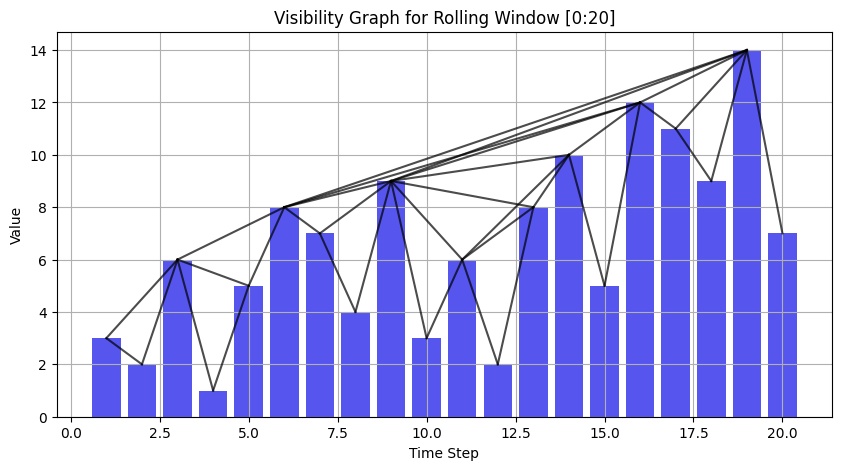

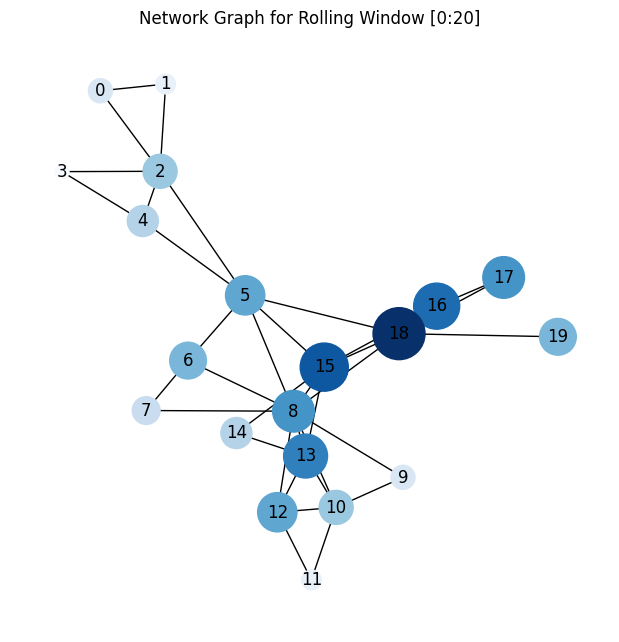

In [82]:


def visibility_graph(time_series):
    """Constructs a Visibility Graph (VG) from a time series window."""
    G = nx.Graph()
    n = len(time_series)

    for i in range(n):
        G.add_node(i, value=time_series[i])

    for i in range(n):
        for j in range(i + 1, n):
            visible = True
            for k in range(i + 1, j):
                if time_series[k] > time_series[i] + (time_series[j] - time_series[i]) * (k - i) / (j - i):
                    visible = False
                    break
            if visible:
                G.add_edge(i, j)

    return G

def rolling_visibility_graphs(time_series, window_size):
    """Generates Visibility Graphs on a rolling window basis."""
    num_windows = len(time_series) - window_size + 1
    rolling_vgs = {}

    for i in range(num_windows):
        window = time_series[i:i + window_size]
        rolling_vgs[i] = visibility_graph(window)

    return rolling_vgs

def plot_visibility_graph(time_series, G, window_start, window_size):
    """Plots the time series with visibility edges for a rolling window."""
    plt.figure(figsize=(10, 5))
    x = np.arange(window_start, window_start + window_size)
    y = time_series[window_start:window_start + window_size]

    # Plot time series in gray
    plt.bar(range(1, len(time_series) + 1), time_series, color='gray', alpha=0.3)

    # Highlight rolling window
    plt.bar(x + 1, y, color='blue', alpha=0.6)

    # Draw visibility edges for this window
    for i, j in G.edges():
        plt.plot([x[i] + 1, x[j] + 1], [y[i], y[j]], 'k-', alpha=0.7)

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Visibility Graph for Rolling Window [{window_start}:{window_start + window_size}]")
    plt.grid(True)
    plt.show()

def plot_network_graph(G, time_series, window_start):
    """Plots the Visibility Graph as a network for a rolling window."""
    pos = nx.spring_layout(G, seed=42)
    node_sizes = [time_series[window_start + i] * 100 for i in G.nodes()]

    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_sizes, cmap=plt.cm.Blues, edge_color="black")
    plt.title(f"Network Graph for Rolling Window [{window_start}:{window_start + len(G.nodes())}]")
    plt.show()

# Example Time Series
time_series = [3, 2, 6, 1, 5, 8, 7, 4, 9, 3, 6, 2, 8, 10, 5, 12, 11, 9, 14, 7]
window_size = len(time_series)  # Adjust window size

# Generate Rolling Visibility Graphs
rolling_vgs = rolling_visibility_graphs(time_series, window_size)

# Visualize Selected Rolling Window
selected_window = 0  # Change this to visualize different rolling windows
plot_visibility_graph(time_series, rolling_vgs[selected_window], selected_window, window_size)
plot_network_graph(rolling_vgs[selected_window], time_series, selected_window)


NodeView((0, 1, 2, 3, 4, 5, 6))

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv("/Users/tarun/0_REPOS/PriceGraph/data/0.csv")

In [104]:
window = 30
k =5
data_x =[]
data_y = []


for t in range(len(df)):
    future_index = t + window + k

    observed_space_end = t + window

    # Stop if we reach the end of the DataFrame (can't calculate future price)
    if future_index >= len(df) - 1:
        break
    X = df.iloc[t:t + window,:][['date', 'high', 'open', 'close', 'low', 'amount', 'vol']]
    # y = df.iloc[t:t + window,:][['label']]

    data_x.append(X.reset_index(drop=True))
    # data_y.append(y)


In [95]:
len(data_x)

2395

In [105]:
def make_label(data_x, window, k):
    label_list = []
    for i in range(0,len(data_x)):

        if i == len(data_x)-1:
            break

        m = list(data_x[i]['close'])[window-1] - list(data_x[i+1]['close'])[k]

        if m > 0:
            label_list.append(1)
        elif m <= 0:
            label_list.append(0)
        del m
    return label_list

label_list = make_label(data_x, window, k)
data_new_x = data_x[:len(label_list)]
# label_list = []
# for i in range(0,len(data_x)):

#     if i == len(data_x)-1:
#         break

#     m = list(data_x[i]['close'])[window-1] - list(data_x[i+1]['close'])[k]
    
#     if m > 0:
#         label_list.append(1)
#     elif m <= 0:
#         label_list.append(0)
#     del m

In [106]:
def make_train_valid(data_x,data_y,tr_portion=0.70):
    train_set_x = data_x[:int(len(data_x) * tr_portion)]
    train_set_y = data_y[:int(len(data_y) * tr_portion)]

    valid_set_x = data_x[int(len(data_x) * tr_portion):]
    valid_set_y = data_y[int(len(data_y) * tr_portion):]

    return train_set_x, train_set_y, valid_set_x, valid_set_y



In [107]:
train_x, train_y, valid_x, valid_y = make_train_valid(data_new_x,label_list,tr_portion=0.70)

In [108]:
len(train_x)

1675

In [109]:
len(train_y)

1675

In [110]:
def make_graph(time_series,window):
    rolling_vgs = rolling_visibility_graphs(time_series, window)
    return rolling_vgs


In [111]:
train_x[1]

date   high   open  close    low        amount       vol
0   20100105  23.90  23.75  23.30  22.75  1.293477e+09  556499.0
1   20100106  23.25  23.25  22.90  22.72  9.444530e+08  412143.0
2   20100107  23.05  22.90  22.65  22.40  8.041660e+08  355336.0
3   20100108  22.75  22.50  22.60  22.35  6.506670e+08  288543.0
4   20100111  23.68  23.50  22.60  22.28  1.009985e+09  442846.0
5   20100112  22.65  22.57  22.45  21.80  1.310069e+09  591795.0
6   20100113  21.90  21.87  20.96  20.80  1.990492e+09  935039.0
7   20100114  21.16  21.00  20.97  20.60  1.089329e+09  521194.0
8   20100115  21.65  21.02  21.43  20.65  1.146375e+09  539508.0
9   20100118  21.76  21.43  21.47  21.21  7.499410e+08  349126.0
10  20100119  22.34  21.58  22.23  21.56  1.438886e+09  650715.0
11  20100120  22.60  22.22  21.38  21.30  1.079326e+09  490835.0
12  20100121  22.80  21.58  22.68  21.38  1.405279e+09  632301.0
13  20100122  23.45  22.44  23.08  21.88  2.002922e+09  882538.0
14  20100125  23.10  22.60  22.19  22.10  8.033200e+08  356058.0
15  20100126  22.59  22.19  22.05  21.60  7.604320e+08  345325.0
16  20100127  22.60  22.39  21.91  21.70  8.923370e+08  401034.0
17  20100128  22.05  21.80  21.75  21.11  5.675670e+08  262132.0
18  20100129  22.35  21.59  21.70  21.32  5.284370e+08  240688.0
19  20100201  21.77  21.71  21.24  21.00  6.026750e+08  283179.0
20  20100202  21.96  21.26  21.37  21.26  6.204750e+08  286733.0
21  20100203  22.58  21.53  22.58  21.24  1.214267e+09  549005.0
22  20100204  22.45  22.33  22.20  22.01  6.752830e+08  303346.0
23  20100205  22.32  21.62  22.00  21.41  6.015150e+08  276174.0
24  20100208  22.08  21.88  21.56  21.45  4.471370e+08  206423.0
25  20100209  22.15  21.60  22.00  21.53  5.431200e+08  248170.0
26  20100210  22.38  22.20  22.28  22.02  5.641770e+08  253839.0
27  20100211  22.35  22.21  22.11  22.08  3.088440e+08  139102.0
28  20100212  22.60  22.17  22.45  22.17  4.224880e+08  188385.0
29  20100222  22.45  22.31  22.10  22.08  3.679330e+08  165777.0

In [117]:
vg

{0: <networkx.classes.graph.Graph at 0x1253b08f0>}

In [239]:
vg = make_graph((train_x[10]['vol']),window = window)

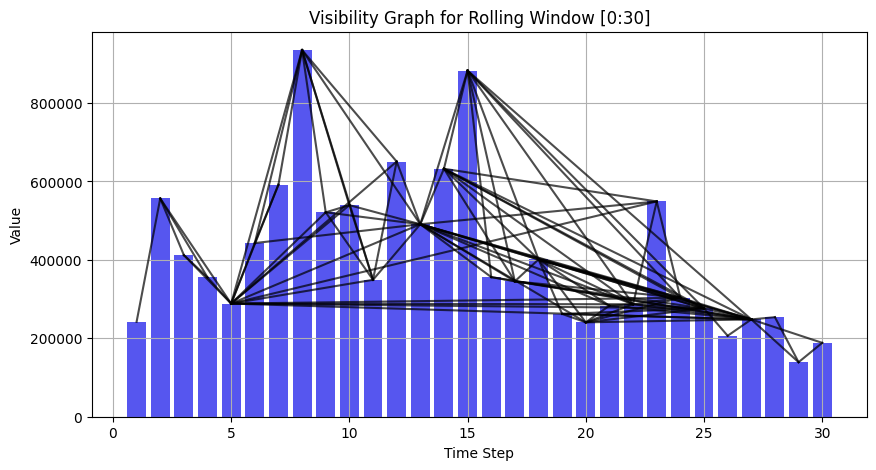

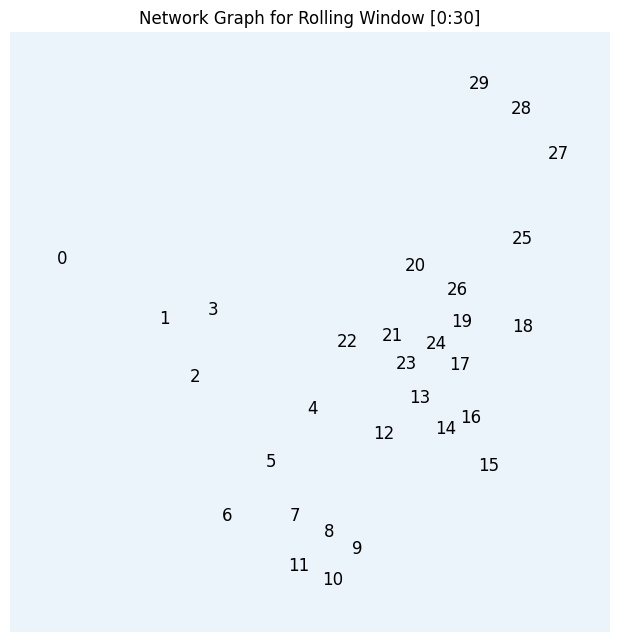

In [242]:

selected_window = 0  # Change this to visualize different rolling windows
window_size = len(train_x[0]['close'])
plot_visibility_graph((train_x[0]['vol']), vg[selected_window], selected_window, window_size)
plot_network_graph(vg[selected_window], (train_x[0]['vol']), selected_window)

Index(['date', 'high', 'open', 'close', 'low', 'amount', 'vol', 'label'], dtype='object')

In [88]:


# ... (your data loading and label creation as before) ...

def timeseries_cv(X, y, n_splits=5):
    """
    Performs time series cross-validation using TimeSeriesSplit.

    Args:
        X (array-like): The features (numpy array or DataFrame).
        y (array-like): The target variable (numpy array or Series).
        n_splits (int): The number of folds.

    Returns:
        list: A list of tuples, where each tuple contains the training and 
              validation indices for a fold.
    """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_indices = []
    for train_index, test_index in tscv.split(X):  # Note: split(X) only
        fold_indices.append((train_index, test_index))
    return fold_indices

# Example usage:
# X = df[['high', 'open', 'close', 'low', 'amount', 'vol']].values  # Features as numpy array
# y = df['label'].values  # Target as numpy array or Series

# fold_indices = timeseries_cv(X, y, n_splits=5)

# for i, (train_index, test_index) in enumerate(fold_indices):
#     print(f"Fold {i+1}:")
#     print("  Train Indices:", train_index)
#     print("  Test Indices:", test_index)

#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

2420

In [129]:


### cross validation

def rolling_cross_validation(features, labels, block_size=1, n_iterations=5):
    """
    Performs rolling cross-validation with a fixed training size.

    Args:
        features: A list of feature arrays [[x1, x2, ...], [x2, x3, ...], ...].
        labels: A list of corresponding labels [y1, y2, ...].
        block_size: The number of data points in each block.
        n_iterations: The number of cross-validation iterations.

    Returns:
        A list of tuples, where each tuple contains:
            - Training features for the iteration.
            - Training labels for the iteration.
            - Validation features for the iteration.
            - Validation labels for the iteration.
    """

    n_samples = len(features)
    max_train_size = (n_iterations -1) * block_size # Fixed training size

    results = []
    for i in range(n_iterations):
        # Define start and end points for this iteration
        train_start = 0 # Start of the training set (fixed at the beginning)
        train_end = train_start + max_train_size
        
        val_start = train_end + (i * block_size) # Start of the current validation block
        val_end = val_start + block_size

        # Extract data for this iteration
        train_features = features[train_start:train_end]
        train_labels = labels[train_start:train_end]
        val_features = features[val_start:val_end]
        val_labels = labels[val_start:val_end]

        results.append((train_features, train_labels, val_features, val_labels))
    return results


# Example Usage:
features = [np.array([i, i+1, i+2]) for i in range(20)] # Example features (replace with your data)
labels = [i*2 for i in range(20)] # Example labels (replace with your data)

block_size = 2  # Adjust as needed
n_iterations = 5 # Adjust as needed

results = rolling_cross_validation(features, labels, block_size, n_iterations)

for i, (train_features, train_labels, val_features, val_labels) in enumerate(results):
    print(f"Iteration {i+1}:")
    print("Train Features:", train_features)
    print("Train Labels:", train_labels)
    print("Val Features:", val_features)
    print("Val Labels:", val_labels)
    print("-" * 20)

Iteration 1:
Train Features: [array([0, 1, 2]), array([1, 2, 3]), array([2, 3, 4]), array([3, 4, 5]), array([4, 5, 6]), array([5, 6, 7]), array([6, 7, 8]), array([7, 8, 9])]
Train Labels: [0, 2, 4, 6, 8, 10, 12, 14]
Val Features: [array([ 8,  9, 10]), array([ 9, 10, 11])]
Val Labels: [16, 18]
--------------------
Iteration 2:
Train Features: [array([0, 1, 2]), array([1, 2, 3]), array([2, 3, 4]), array([3, 4, 5]), array([4, 5, 6]), array([5, 6, 7]), array([6, 7, 8]), array([7, 8, 9])]
Train Labels: [0, 2, 4, 6, 8, 10, 12, 14]
Val Features: [array([10, 11, 12]), array([11, 12, 13])]
Val Labels: [20, 22]
--------------------
Iteration 3:
Train Features: [array([0, 1, 2]), array([1, 2, 3]), array([2, 3, 4]), array([3, 4, 5]), array([4, 5, 6]), array([5, 6, 7]), array([6, 7, 8]), array([7, 8, 9])]
Train Labels: [0, 2, 4, 6, 8, 10, 12, 14]
Val Features: [array([12, 13, 14]), array([13, 14, 15])]
Val Labels: [24, 26]
--------------------
Iteration 4:
Train Features: [array([0, 1, 2]), array([

In [130]:
features

[array([0, 1, 2]),
 array([1, 2, 3]),
 array([2, 3, 4]),
 array([3, 4, 5]),
 array([4, 5, 6]),
 array([5, 6, 7]),
 array([6, 7, 8]),
 array([7, 8, 9]),
 array([ 8,  9, 10]),
 array([ 9, 10, 11]),
 array([10, 11, 12]),
 array([11, 12, 13]),
 array([12, 13, 14]),
 array([13, 14, 15]),
 array([14, 15, 16]),
 array([15, 16, 17]),
 array([16, 17, 18]),
 array([17, 18, 19]),
 array([18, 19, 20]),
 array([19, 20, 21])]

In [153]:


def generate_graph_embedding_pytorch_geometric(num_nodes, edge_index, feature_dimension, num_layers, pooling_method):
    """Generates graph embeddings using PyTorch Geometric's GCNConv."""

    # Create random node features (replace with your actual features)
    x = torch.randn(num_nodes, feature_dimension)

    # Create the graph data object
    data = Data(x=x, edge_index=edge_index)
    data.batch = torch.zeros(num_nodes, dtype=torch.long)  # Batch tensor (important!)

    # Define the GCN model
    class GCN(torch.nn.Module):
        def __init__(self, hidden_channels, num_layers):
            super().__init__()
            self.convs = torch.nn.ModuleList()
            self.convs.append(GCNConv(feature_dimension, hidden_channels))  # Input layer
            for _ in range(num_layers - 2): # Hidden Layers
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.convs.append(GCNConv(hidden_channels, feature_dimension)) # Output layer
            self.relu = torch.nn.ReLU()

        def forward(self, x, edge_index):
            for conv in self.convs[:-1]:
                x = conv(x, edge_index)
                x = self.relu(x)  # Activation function
            x = self.convs[-1](x, edge_index) # Last layer without activation

            return x

    # model = GCN(hidden_channels=64, num_layers=num_layers)  # You can adjust hidden_channels
    # embeddings = model(data.x, data.edge_index)
    model = GCN(hidden_channels=feature_dimension, num_layers=num_layers)
    node_embeddings = model(data.x, data.edge_index)  # Get node embeddings first

    # Pooling to get a graph-level embedding
    if pooling_method == "mean":
        graph_embedding = global_mean_pool(node_embeddings, data.batch)  # Mean pooling
    elif pooling_method == "sum":
        graph_embedding = global_add_pool(node_embeddings, data.batch)  # Sum pooling
    elif pooling_method == "max":
        graph_embedding = global_max_pool(node_embeddings, data.batch)  # Max pooling
    else:
        raise ValueError("Invalid pooling method. Choose 'mean', 'sum', or 'max'.")

    return graph_embedding



# # Example usage (important change here):
# num_nodes = 20
# edge_probability = 0.3
# feature_dimension = 64
# num_layers = 1
# pooling_method = "mean"  # Choose your pooling method

# # Create a random graph and convert it to PyTorch Geometric's edge_index format
# import networkx as nx
# graph = nx.gnp_random_graph(num_nodes, edge_probability)



# edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()


# # data.batch = torch.zeros(num_nodes, dtype=torch.long) # Creates a batch tensor


# graph_embedding = generate_graph_embedding_pytorch_geometric(num_nodes, edge_index, feature_dimension, num_layers, pooling_method)

# print("Shape of graph embedding:", graph_embedding.shape)  # Should be (1, feature_dimension)
# print("Graph embedding:\n", graph_embedding)



In [148]:
num_nodes = window
feature_dimension = 64
num_layers = 1
pooling_method = "mean"
graph = vg[0]

edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

In [137]:
edge_index

tensor([[ 0,  1,  1,  1,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  9,  9,  9, 10, 10,
         11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14,
         14, 14, 15, 16, 17, 17, 17, 17, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20,
         20, 20, 20, 20, 21, 21, 21, 21, 22, 23, 23, 24, 24, 25, 26, 27, 27, 28],
        [ 1,  2,  3,  4,  3,  4,  5,  6,  7,  8,  9, 11, 12, 17, 19, 24, 25, 26,
         27,  6,  7,  9, 12,  7,  9, 12,  8,  9, 12,  9, 12, 10, 11, 12, 11, 12,
         12, 13, 14, 16, 17, 19, 24, 25, 26, 27, 14, 16, 17, 19, 26, 27, 15, 16,
         17, 27, 16, 17, 18, 19, 26, 27, 19, 20, 22, 23, 24, 25, 26, 27, 21, 22,
         23, 24, 26, 27, 22, 23, 24, 26, 23, 24, 26, 25, 26, 26, 27, 28, 29, 29]])

In [154]:


# gr.batch = torch.zeros(num_nodes, dtype=torch.long) # Creates a batch tensor

def make_embedding(time_series, window, feature_dimension, num_layers, pooling_method):
    vg = make_graph(time_series, window)
    graph = vg[0]
    num_nodes = window
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    graph_embedding = generate_graph_embedding_pytorch_geometric(num_nodes, edge_index, feature_dimension, num_layers, pooling_method)
    return graph_embedding

# vg = make_graph(train_x[10]['close'],window = window)
# num_nodes = window
# feature_dimension = 64
# num_layers = 1
# pooling_method = "mean"
# graph = vg[0]

# edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

# graph_embedding = generate_graph_embedding_pytorch_geometric(num_nodes, edge_index, feature_dimension, num_layers, pooling_method)

# print("Shape of graph embedding:", graph_embedding.shape)  # Should be (1, feature_dimension)
# print("Graph embedding:\n", graph_embedding)


In [158]:
col_types = ['high', 'open', 'close', 'low', 'amount', 'vol']

In [162]:
emb_comb = []
for i in col_types:
    # print(i)
    emb = make_embedding(train_x[0][i], window=window, feature_dimension=64, num_layers=1, pooling_method="mean")
    emb_comb.append(emb)
concatenated_tensor = torch.cat(emb_comb, dim=1)
# print("Shape of graph embedding:", emb.shape)  # Should be (1, feature_dimension)
# print("Graph embedding:\n", emb)


In [171]:
concatenated_tensor.shape

torch.Size([1, 384])

In [172]:
train_y[0]
#1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64 

0

In [170]:
sigmoid = torch.nn.Sigmoid()
sigmoid(concatenated_tensor.squeeze(1))

tensor([[0.4417, 0.5587, 0.5049, 0.4202, 0.5402, 0.5099, 0.4252, 0.5329, 0.4543,
         0.5365, 0.5053, 0.6034, 0.5232, 0.4693, 0.5711, 0.5282, 0.5176, 0.5505,
         0.4909, 0.4202, 0.4850, 0.4087, 0.4571, 0.6166, 0.5608, 0.5946, 0.4895,
         0.6116, 0.5039, 0.4985, 0.5105, 0.4383, 0.4683, 0.5007, 0.5567, 0.4121,
         0.4899, 0.5325, 0.5871, 0.3856, 0.6786, 0.4651, 0.4603, 0.4598, 0.3966,
         0.4901, 0.4316, 0.5624, 0.5301, 0.4880, 0.5483, 0.4040, 0.4950, 0.3844,
         0.5318, 0.4788, 0.3394, 0.4747, 0.5920, 0.5570, 0.4093, 0.5282, 0.4757,
         0.5421, 0.5266, 0.5809, 0.6046, 0.4690, 0.4410, 0.5208, 0.5042, 0.4935,
         0.4705, 0.3640, 0.3325, 0.5031, 0.4425, 0.5757, 0.4343, 0.5050, 0.3730,
         0.5572, 0.2807, 0.5727, 0.4246, 0.4847, 0.5711, 0.6665, 0.6500, 0.3819,
         0.4572, 0.5349, 0.4686, 0.4589, 0.4188, 0.6002, 0.4771, 0.4064, 0.3586,
         0.6367, 0.4192, 0.3543, 0.4722, 0.4930, 0.5567, 0.3284, 0.6855, 0.5272,
         0.5127, 0.4618, 0.6

In [176]:
train_x

[        date   high   open  close    low        amount       vol
 0   20100104  24.58  24.52  23.71  23.68  5.802490e+08  241922.0
 1   20100105  23.90  23.75  23.30  22.75  1.293477e+09  556499.0
 2   20100106  23.25  23.25  22.90  22.72  9.444530e+08  412143.0
 3   20100107  23.05  22.90  22.65  22.40  8.041660e+08  355336.0
 4   20100108  22.75  22.50  22.60  22.35  6.506670e+08  288543.0
 5   20100111  23.68  23.50  22.60  22.28  1.009985e+09  442846.0
 6   20100112  22.65  22.57  22.45  21.80  1.310069e+09  591795.0
 7   20100113  21.90  21.87  20.96  20.80  1.990492e+09  935039.0
 8   20100114  21.16  21.00  20.97  20.60  1.089329e+09  521194.0
 9   20100115  21.65  21.02  21.43  20.65  1.146375e+09  539508.0
 10  20100118  21.76  21.43  21.47  21.21  7.499410e+08  349126.0
 11  20100119  22.34  21.58  22.23  21.56  1.438886e+09  650715.0
 12  20100120  22.60  22.22  21.38  21.30  1.079326e+09  490835.0
 13  20100121  22.80  21.58  22.68  21.38  1.405279e+09  632301.0
 14  20100

In [188]:
def data_frame_entry(ds):
    data_section = ds
    col_types = ['high', 'open', 'close', 'low', 'amount', 'vol']
    emb_comb = []
    for i in col_types:
        emb = make_embedding(data_section[i], window=window, feature_dimension=64, num_layers=1, pooling_method="mean")  ##data_section train_x[0]
        emb_comb.append(emb)
    concatenated_tensor = torch.cat(emb_comb, dim=1)
    return concatenated_tensor

In [179]:
concatenated_tensor

tensor([[-2.3430e-01,  2.3583e-01,  1.9637e-02, -3.2190e-01,  1.6095e-01,
          3.9490e-02, -3.0146e-01,  1.3168e-01, -1.8337e-01,  1.4631e-01,
          2.1372e-02,  4.1985e-01,  9.2964e-02, -1.2285e-01,  2.8622e-01,
          1.1286e-01,  7.0579e-02,  2.0263e-01, -3.6320e-02, -3.2180e-01,
         -6.0198e-02, -3.6954e-01, -1.7204e-01,  4.7521e-01,  2.4453e-01,
          3.8311e-01, -4.2154e-02,  4.5414e-01,  1.5487e-02, -5.8868e-03,
          4.2098e-02, -2.4817e-01, -1.2693e-01,  2.9205e-03,  2.2788e-01,
         -3.5542e-01, -4.0265e-02,  1.3015e-01,  3.5206e-01, -4.6571e-01,
          7.4725e-01, -1.3974e-01, -1.5918e-01, -1.6097e-01, -4.1976e-01,
         -3.9643e-02, -2.7517e-01,  2.5103e-01,  1.2055e-01, -4.8041e-02,
          1.9370e-01, -3.8869e-01, -1.9804e-02, -4.7089e-01,  1.2736e-01,
         -8.4744e-02, -6.6597e-01, -1.0117e-01,  3.7217e-01,  2.2903e-01,
         -3.6668e-01,  1.1273e-01, -9.7339e-02,  1.6865e-01,  1.0667e-01,
          3.2656e-01,  4.2455e-01, -1.

In [ ]:
numpy_array = concatenated_tensor.detach().numpy()  # Detach from PyTorch graph and convert to NumPy

# Create the Pandas DataFrame
df = pd.DataFrame(numpy_array)

# (Optional but highly recommended) Add column names 
# If you know what the features represent, replace 'feature_1', 'feature_2', etc. with actual names
num_cols = df.shape[1]  # Get the number of columns
df.columns = [f'feature_{i}' for i in range(num_cols)]  # Generates names like 'feature_0', 'feature_1', ...

# Now df is a Pandas DataFrame ready for XGBoost
print(df.head()) # Display the first few rows



In [198]:
from tqdm import tqdm

In [216]:
for i in tqdm(range(0,1675)):
    
    concatenated_tensor = data_frame_entry(train_x[i])
    numpy_array = concatenated_tensor.detach().numpy() 

    if i == 0:
        num_cols = numpy_array.shape[1]  
        df = pd.DataFrame(numpy_array,columns=[f'feature_{i}' for i in range(num_cols)])
    else:
        df = pd.concat([df,pd.DataFrame(numpy_array,columns=[f'feature_{i}' for i in range(num_cols)])],axis=0)

    del numpy_array, concatenated_tensor

100%|██████████| 1675/1675 [00:48<00:00, 34.32it/s]


In [217]:
df['label'] = train_y

In [211]:
for i in tqdm(range(0,719)):
    
    concatenated_tensor = data_frame_entry(valid_x[i])
    numpy_array = concatenated_tensor.detach().numpy() 

    if i == 0:
        num_cols = numpy_array.shape[1]  
        valid_df = pd.DataFrame(numpy_array,columns=[f'feature_{i}' for i in range(num_cols)])
    else:
        valid_df = pd.concat([valid_df,pd.DataFrame(numpy_array,columns=[f'feature_{i}' for i in range(num_cols)])],axis=0)

    del numpy_array, concatenated_tensor



  0%|          | 0/719 [00:00<?, ?it/s]

100%|██████████| 719/719 [00:20<00:00, 34.65it/s]


In [213]:
valid_df['label'] = valid_y

719

In [222]:
df.iloc[:,:384]

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   -0.285458  -0.599775  -0.067421  -0.039972  -0.424232  -0.903997   
0    0.427073   0.164883  -0.058115   0.023917   0.394706   0.101890   
0   -0.047553  -0.036075   0.143905   0.297069  -0.279563  -0.042676   
0   -0.500081  -0.211572  -0.042446   0.259850  -0.503522  -0.264461   
0   -0.097228  -0.709391  -0.058426  -0.158569  -0.123315   0.122064   
..        ...        ...        ...        ...        ...        ...   
0   -0.057100  -0.164261  -0.099616  -0.085106  -0.353543  -0.332095   
0    0.179826   0.043613   0.457871  -0.319200   0.036599   0.080298   
0   -0.318891  -0.237649  -0.322372  -0.500092   0.134061   0.199165   
0   -0.141037   0.127653   0.483844  -0.205164   0.058993  -0.259306   
0    0.743134  -0.452011   0.035901   0.028167   0.329736   0.429303   

    feature_6  feature_7  feature_8  feature_9  ...  feature_374  feature_375  \
0   -0.355360   0.588467  -0.125667  -0.179791  ...     0.253362     0.138528   
0    0.421330   0.005301  -0.252116  -0.111950  ...     0.368130     0.375289   
0   -0.559934   0.506254   0.378779   0.642154  ...     0.151244     0.278719   
0   -0.138919  -0.237502   0.574284   0.250502  ...     0.103396     0.139411   
0   -0.371838  -0.385651   0.249482  -0.515453  ...     0.121533    -0.373317   
..        ...        ...        ...        ...  ...          ...          ...   
0    0.161304  -0.369620  -0.016427  -0.151638  ...     0.170607    -0.092334   
0    0.237583  -0.208471   0.566725  -0.169092  ...     0.284602    -0.467660   
0   -0.315968  -0.249015  -0.171398  -0.015517  ...    -0.025631     0.069299   
0    0.153892   0.448540  -0.655453   0.013557  ...    -0.257628    -0.146380   
0    0.214649  -0.317761  -0.194270  -0.533387  ...    -0.021844     0.021905   

    feature_376  feature_377  feature_378  feature_379  feature_380  \
0      0.456069    -0.068981    -0.244792     0.227779     0.425940   
0     -0.351211     0.187696    -0.110509    -0.312900     0.315030   
0     -0.004165    -0.269490     0.008475    -0.094665     0.314117   
0     -0.027797    -0.469026     0.177892    -0.631073    -0.443657   
0     -0.358122    -0.048800     0.240107    -0.434285     0.012744   
..          ...          ...          ...          ...          ...   
0      0.127113    -0.224814     0.073197     0.082891     0.641204   
0     -0.273728    -0.011476    -0.694505     0.448982     0.628476   
0      0.547275    -0.237023     0.672336    -0.541570    -0.445486   
0      0.245457    -0.334338     0.240823     0.253900     0.229239   
0      0.214129     0.413408    -0.018048     0.254869    -0.314143   

    feature_381  feature_382  feature_383  
0     -0.156183     0.353425    -0.425794  
0      0.180875    -0.015872    -0.453746  
0     -0.390022    -0.043726     0.067701  
0      0.031594     0.333757    -0.585107  
0      0.074372     0.071648    -0.159084  
..          ...          ...          ...  
0      0.138330    -0.077247     0.099109  
0     -0.154282    -0.088586    -0.030598  
0      0.374886     0.211282    -0.717461  
0      0.149981     0.299353     0.255648  
0      0.090253     0.536905     0.247617  

[1675 rows x 384 columns]

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score  # Or other metrics

# ... Load your data (X: features, y: labels) ...
X = df.iloc[:,:384]
X = df.iloc[:,385]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier (or regressor)
model = xgb.XGBClassifier(
    n_estimators=1000,  # Start with a large number, early stopping will adjust
    learning_rate=0.1,
    max_depth=5,
    # ... other hyperparameters ...
    use_label_encoder=False,  # Suppress warning
    eval_metric='logloss' # Or other metric
)

# Train with early stopping
model.fit(X_train, y_train,
          early_stopping_rounds=10,  # Stop if no improvement for 10 rounds
          eval_set=[(X_test, y_test)],  # Use test set for early stopping
          verbose=True)

[0]	validation_0-logloss:0.69197
[1]	validation_0-logloss:0.69504
[2]	validation_0-logloss:0.69316
[3]	validation_0-logloss:0.68955
[4]	validation_0-logloss:0.69180


/Users/tarun/0_REPOS/PriceGraph/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.69444
[6]	validation_0-logloss:0.69711
[7]	validation_0-logloss:0.69525
[8]	validation_0-logloss:0.69300
[9]	validation_0-logloss:0.69307
[10]	validation_0-logloss:0.69205
[11]	validation_0-logloss:0.69075
[12]	validation_0-logloss:0.69228
[13]	validation_0-logloss:0.69240
[14]	validation_0-logloss:0.69138
[15]	validation_0-logloss:0.69443
[16]	validation_0-logloss:0.69303
[17]	validation_0-logloss:0.69440
[18]	validation_0-logloss:0.69479
[19]	validation_0-logloss:0.69163
[20]	validation_0-logloss:0.69113
[21]	validation_0-logloss:0.69378
[22]	validation_0-logloss:0.69392
[23]	validation_0-logloss:0.69503
[24]	validation_0-logloss:0.69552
[25]	validation_0-logloss:0.69515
[26]	validation_0-logloss:0.69593
[27]	validation_0-logloss:0.69825
[28]	validation_0-logloss:0.70067
[29]	validation_0-logloss:0.70120
[30]	validation_0-logloss:0.70165
[31]	validation_0-logloss:0.70242
[32]	validation_0-logloss:0.70294
[33]	validation_0-logloss:0.70347
[34]	validation_0-l

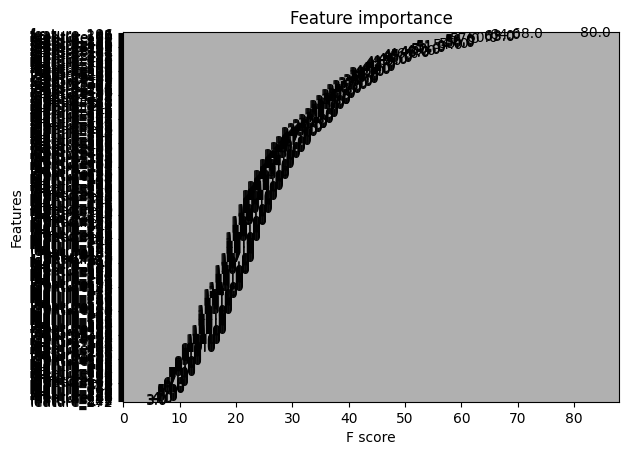

/Users/tarun/0_REPOS/PriceGraph/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:02:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "enable_categorical", "missing", "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.786613       0.016759       0.501853      0.040620
1        0.860990       0.012730       0.494139      0.023723
2        0.903132       0.007297       0.498730      0.010211
3        0.930250       0.007372       0.497378      0.014145
4        0.948919       0.010000       0.508006      0.007179
5        0.962136       0.006182       0.508807      0.005903
6        0.973695       0.003572       0.515605      0.006783
7        0.981210       0.003716       0.516823      0.012238
8        0.985371       0.003112       0.513329      0.016091
9        0.989780       0.002587       0.513767      0.018485


In [226]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # More metrics
import pandas as pd # Import pandas for data manipulation

# ... Load your data (X: features, y: labels) ...
# Assuming your data is in a Pandas DataFrame called 'df'
X = df.iloc[:, :384]  # Features (all columns except the last one)
y = df.iloc[:, 384]  # Target variable (last column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratified split

# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    # Add other hyperparameters like:
    # subsample=0.8,  # Fraction of samples used for each tree
    # colsample_bytree=0.8, # Fraction of features used for each tree
    # gamma=0.1,         # Minimum loss reduction required to make a further partition on a leaf node
    # reg_alpha=1,       # L1 regularization term on weights
    # reg_lambda=1,      # L2 regularization term on weights
    objective='binary:logistic',  # Explicitly set for binary classification
    use_label_encoder=False,
    eval_metric='logloss'  # Or 'auc', 'error', 'binary:logistic'
)

# Train with early stopping
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=True)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# More comprehensive evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Feature importance
print(model.feature_importances_)
# or plot feature importance
xgb.plot_importance(model)
plt.show()

# Cross-validation (optional, but highly recommended)
cv_scores = xgb.cv(dtrain=xgb.DMatrix(X, label=y), params=model.get_params(), nfold=5, metrics='auc', as_pandas=True)
print(cv_scores)

In [228]:
valid_x = valid_df.iloc[:, :384]  # Features (all columns except the last one)
valid_y = valid_df.iloc[:, 384]  # Target variable (last column)

y_pred = model.predict(valid_x)
y_pred_proba = model.predict_proba(valid_x)#[:, 1]  # Get probabilities for the positive class

# Evaluate the model
accuracy = accuracy_score(valid_y, y_pred)
print(accuracy)

print(classification_report(valid_y, y_pred))
print(confusion_matrix(valid_y, y_pred))

0.5354659248956884
              precision    recall  f1-score   support

           0       0.47      0.72      0.56       302
           1       0.66      0.41      0.50       417

    accuracy                           0.54       719
   macro avg       0.56      0.56      0.53       719
weighted avg       0.58      0.54      0.53       719

[[216  86]
 [248 169]]


In [229]:
valid_df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   -0.717005   0.363089   0.373860   0.703785  -0.245594  -0.053730   
0   -0.082797   0.273521   0.028363   0.542951  -0.403203   0.381717   
0    0.657192  -0.379585   0.223081  -0.173945   0.115457   0.929066   
0    0.201313   0.249691  -0.315699  -0.047686  -0.551770   0.780307   
0   -0.685100  -0.169452   0.318251  -0.213053   0.194136   0.541297   
..        ...        ...        ...        ...        ...        ...   
0    0.144560   0.536567   0.079842   0.150953   0.059902   0.329371   
0    0.454663  -0.564504   0.119083   0.198930  -0.426653   0.318930   
0    0.155467  -0.240070  -0.035779  -0.119444  -0.463376   0.064242   
0    0.455504   0.193032   0.011876   0.292526  -0.241240  -0.135102   
0    0.329075  -0.570078  -0.278249   0.185723   0.362675   0.074372   

    feature_6  feature_7  feature_8  feature_9  ...  feature_375  feature_376  \
0    0.082392  -0.753840  -0.587339   0.055989  ...     0.485128    -0.539732   
0   -0.071221  -0.384507  -0.330575  -0.266042  ...     0.503414    -0.004537   
0   -0.064504  -0.458060   0.358882  -0.561885  ...    -0.033036     0.307278   
0    0.459805   0.202234   0.207572   0.290313  ...    -0.346978    -0.142039   
0   -0.139861   0.856282   0.311087   0.974232  ...     0.008802    -0.646667   
..        ...        ...        ...        ...  ...          ...          ...   
0    0.053714   0.045274  -0.031142  -0.074420  ...    -0.134201    -0.058539   
0    0.106041  -0.269393   0.213757  -0.277710  ...     0.095321     0.228002   
0    0.437665   0.492841  -0.540700  -0.088849  ...     0.578926    -0.628004   
0   -0.159937  -0.027481   0.306453   0.079989  ...    -0.072623     0.261290   
0   -0.199490  -0.434525  -0.375170  -0.427122  ...     0.070862    -0.182634   

    feature_377  feature_378  feature_379  feature_380  feature_381  \
0      0.603879    -0.319690     0.196521    -0.142228     0.684275   
0      0.505268    -0.007106    -0.037041     0.262830    -0.121394   
0      0.314140    -0.214303     0.587292     0.003578    -0.358417   
0      0.569874    -0.295030     0.412446    -0.205707    -0.716027   
0      0.001476    -0.440566     0.254985     0.675756     0.129326   
..          ...          ...          ...          ...          ...   
0      0.167424     0.208617    -0.077572    -0.183774    -0.026183   
0      0.541617    -0.041369    -0.010292     0.466693     0.174268   
0      0.523415    -0.050432    -0.217347    -0.376738     0.341984   
0     -0.128406    -0.236489     0.406217     0.143040     0.575280   
0     -0.399602     0.184455    -0.463929    -0.128188     0.207584   

    feature_382  feature_383  label  
0     -0.394185    -0.106219      0  
0     -0.426306     0.063143      0  
0     -0.024248     0.241042      0  
0      0.713421     0.349897      0  
0      1.132770     0.412856      0  
..          ...          ...    ...  
0      0.039979    -0.205357      0  
0     -0.087384    -0.432971      0  
0      0.072037     0.159294      1  
0      0.043782    -0.267616      1  
0     -0.547820    -0.682508      1  

[719 rows x 385 columns]

In [ ]:
valid_set_x = data_new_x[int(len(data_new_x) * 0.7):]
# valid_set_y = data_new_x[int(len(data_new_x) * tr_portion):]

In [246]:
len(valid_set_x )

719

In [249]:


for i in tqdm(range(0,719)):

    if i == 0:
        valid_ts = valid_set_x[i].head(1)
    elif i != 0 and i < 719:
        valid_ts = pd.concat([valid_ts,valid_set_x[i].head(1)],axis=0)
    else:
        valid_ts = pd.concat([valid_ts,valid_set_x[i]],axis=0)


100%|██████████| 719/719 [00:00<00:00, 4275.97it/s]


In [254]:
valid_ts['tag'] = valid_y

In [257]:
valid_ts.reset_index(drop=True,inplace=True)

In [259]:
valid_ts.tail(3)

date   high   open  close    low        amount       vol  tag
716  20191106  17.26  17.06  16.96  16.88  1.470233e+09  863325.0    1
717  20191107  17.07  16.93  16.89  16.75  1.200672e+09  711896.0    1
718  20191108  17.02  16.98  16.65  16.64  1.421088e+09  849139.0    1

In [261]:
def backtest(df, initial_capital=10000):
    portfolio_value = initial_capital
    cash = initial_capital
    shares_held = 0
    portfolio_history = []  # To store portfolio value over time
    trades = [] # To store trade information

    for i in range(1, len(df)):  # Start from 1 to access previous row
        signal = df['tag'][i]
        price = df['close'][i]
        prev_price = df['close'][i-1] # Previous price

        if signal == 1:  # Buy
            if cash > 0:  # Check if you have enough cash
                num_shares_to_buy = int(cash / price) #Buy maximum shares
                cash -= num_shares_to_buy * price
                shares_held += num_shares_to_buy
                trades.append({'date':df.index[i], 'type':'buy', 'price':price, 'quantity':num_shares_to_buy})

        elif signal == -1:  # Sell
            if shares_held > 0:
                cash += shares_held * price
                shares_held = 0
                trades.append({'date':df.index[i], 'type':'sell', 'price':price, 'quantity':shares_held})

        # Calculate portfolio value
        portfolio_value = cash + shares_held * price
        portfolio_history.append({'date':df.index[i], 'value':portfolio_value})

    return pd.DataFrame(portfolio_history).set_index('date'), pd.DataFrame(trades)

portfolio_history, trades = backtest(valid_ts, initial_capital=10000)
print(portfolio_history.head())
print(trades)

        value
date         
1     10000.0
2     10000.0
3     10000.0
4     10000.0
5     10000.0
     date type  price  quantity
0       9  buy   9.65      1036
1      10  buy   9.50         0
2      11  buy   9.42         0
3      12  buy   9.40         0
4      13  buy   9.25         0
..    ...  ...    ...       ...
412   690  buy  15.18         0
413   691  buy  15.75         0
414   716  buy  16.96         0
415   717  buy  16.89         0
416   718  buy  16.65         0

[417 rows x 4 columns]


In [264]:
def backtest_with_tags(df, initial_capital=10000):
    portfolio_value = initial_capital
    cash = initial_capital
    holdings = {}  # Dictionary to store shares held for each tag
    portfolio_history = []
    trades = []

    for i in range(len(df)):
        signal = df['tag'][i]
        price = df['close'][i]

        if signal:  # If there's a buy signal
            tag_to_buy = signal
            if tag_to_buy not in holdings:
                holdings[tag_to_buy] = 0  # Initialize if not already holding

            if cash > 0:
                num_shares_to_buy = int(cash / price)
                if num_shares_to_buy > 0: # Check if num_shares_to_buy > 0
                    cash -= num_shares_to_buy * price
                    holdings[tag_to_buy] += num_shares_to_buy
                    trades.append({'date':df.index[i], 'type':'buy', 'tag':tag_to_buy, 'price':price, 'quantity':num_shares_to_buy})

        # Calculate portfolio value (sum of holdings for each tag)
        portfolio_value = cash
        for tag, shares in holdings.items():
            # Get the current price for the tag (you'll need to look this up)
            # In this example, we assume there is only one asset per tag
            tag_price = df['close'][i] # In a real scenario, you would need to filter dataframe based on the tag
            portfolio_value += shares * tag_price

        portfolio_history.append({'date':df.index[i], 'value':portfolio_value})

    return pd.DataFrame(portfolio_history).set_index('date'), pd.DataFrame(trades)

portfolio_history, trades = backtest_with_tags(valid_ts, initial_capital=10000)
print(portfolio_history.head())
print(trades)

        value
date         
0     10000.0
1     10000.0
2     10000.0
3     10000.0
4     10000.0
   date type  tag  price  quantity
0     9  buy    1   9.65      1036


In [271]:
portfolio_history

value
date          
0     10000.00
1     10000.00
2     10000.00
3     10000.00
4     10000.00
...        ...
714   17531.72
715   17770.00
716   17573.16
717   17500.64
718   17252.00

[719 rows x 1 columns]

In [276]:
valid_ts['tag'].value_counts()

tag
1    417
0    302
Name: count, dtype: int64

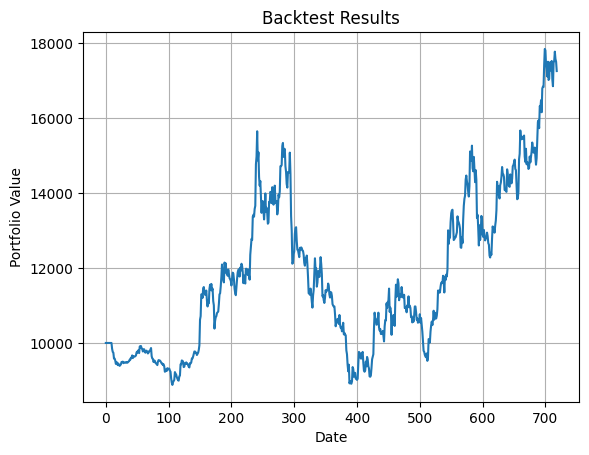

Sharpe Ratio: 0.7759411640128965
Max Drawdown: 6734.0


In [269]:
import matplotlib.pyplot as plt

# Plot portfolio value
plt.plot(portfolio_history['value'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Backtest Results')
plt.grid(True)
plt.show()

# Calculate key metrics (example)
returns = portfolio_history['value'].pct_change()
sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()  # Assuming 252 trading days
max_drawdown = (portfolio_history['value'].cummax() - portfolio_history['value']).max()

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")

# ... other metrics:  annualized return, Sortino ratio, etc.

In [277]:
valid_ts

date   high   open  close    low        amount        vol  tag
0    20161128   9.78   9.69   9.63   9.60  1.240686e+09  1279689.0    0
1    20161129   9.70   9.59   9.62   9.55  8.543080e+08   887779.0    0
2    20161130   9.72   9.65   9.55   9.50  9.857580e+08  1025963.0    0
3    20161201   9.63   9.57   9.60   9.55  6.196330e+08   646004.0    0
4    20161202   9.60   9.60   9.55   9.44  7.900440e+08   829686.0    0
..        ...    ...    ...    ...    ...           ...        ...  ...
714  20191104  17.25  16.98  16.92  16.77  1.507911e+09   889824.0    0
715  20191105  17.44  16.80  17.15  16.79  2.010924e+09  1172485.0    0
716  20191106  17.26  17.06  16.96  16.88  1.470233e+09   863325.0    1
717  20191107  17.07  16.93  16.89  16.75  1.200672e+09   711896.0    1
718  20191108  17.02  16.98  16.65  16.64  1.421088e+09   849139.0    1

[719 rows x 8 columns]

In [303]:

def backtest_buy_hold(data, initial_capital=1000):
    """
    Backtests a buy-and-hold strategy based on a 'tag' column.

    Buys and holds only when tag is 1, otherwise does not hold.

    Args:
        data (pd.DataFrame): DataFrame with 'date', 'open', and 'tag' columns.
        initial_capital (float): Starting portfolio amount.

    Returns:
        pd.DataFrame: DataFrame with added 'position', 'returns', 'portfolio_value',
                      and 'cumulative_returns' columns.
        dict: Dictionary containing performance metrics.
    """

    df = data.copy()
    df.sort_index(inplace=True)

    df['position'] = 0
    df['position'] = np.where(df['tag'] == 1, 1, 0)  # 1 for buy and hold, 0 for no holding

    df['returns'] = 0.0
    df['portfolio_value'] = initial_capital

    shares_held = 0  # Track the number of shares held
    cash = initial_capital  # Track the cash available

    for i in range(1, len(df)):
        if df['position'][i - 1] == 1 and shares_held == 0:  # Buy if tag is 1 and no shares held
            shares_held = cash / df['open'][i-1] # Buy as many shares as possible with available cash at previous day's open price.
            cash = 0  # Invest all cash

        if shares_held > 0:  # If shares are held, calculate returns
            df['returns'][i] = (df['open'][i] - df['open'][i - 1]) / df['open'][i - 1]

        # Portfolio Value Update
        df['portfolio_value'][i] = cash + shares_held * df['open'][i]  # Portfolio value is cash + value of shares
    
    df['cumulative_returns'] = (df['portfolio_value'] / initial_capital) - 1

    # Performance Metrics Calculation (Same as before)
    total_return = df['cumulative_returns'].iloc[-1]
    peak = df['portfolio_value'].cummax()
    drawdown = (peak - df['portfolio_value']) / peak
    max_drawdown = drawdown.max()

    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        # ... (Add other metrics)
    }
        # --- Plotting ---
    plt.figure(figsize=(12, 6))  # Set the figure size

    # Plot 1: Portfolio Value
    plt.subplot(2, 1, 1)  # Create the first subplot
    plt.plot(df.index, df['portfolio_value'])
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')

    # Plot 2: Cumulative Returns
    plt.subplot(2, 1, 2)  # Create the second subplot
    plt.plot(df.index, df['cumulative_returns'])
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()


    return df, metrics



/var/folders/92/4f2bcqtn7m3fyk16q_s4_0yh0000gn/T/ipykernel_10185/2542032346.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['portfolio_value'][i] = cash + shares_held * df['open'][i]  # Portfolio value is cash + value of shares
/var/

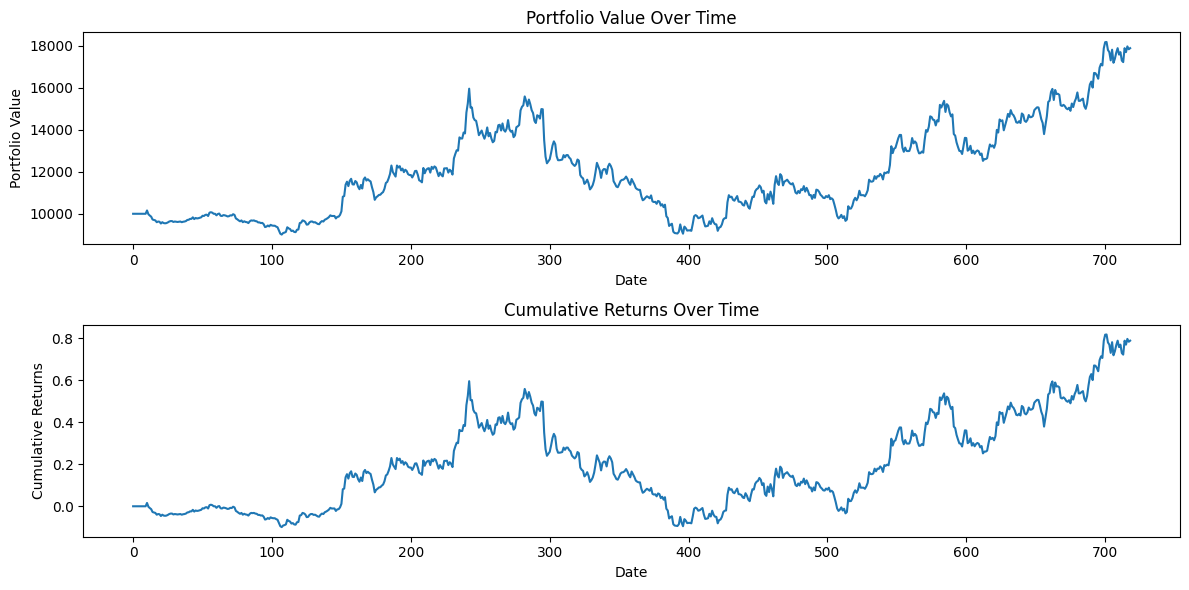

(         date   high   open  close    low        amount        vol  tag  \
 0    20161128   9.78   9.69   9.63   9.60  1.240686e+09  1279689.0    0   
 1    20161129   9.70   9.59   9.62   9.55  8.543080e+08   887779.0    0   
 2    20161130   9.72   9.65   9.55   9.50  9.857580e+08  1025963.0    0   
 3    20161201   9.63   9.57   9.60   9.55  6.196330e+08   646004.0    0   
 4    20161202   9.60   9.60   9.55   9.44  7.900440e+08   829686.0    0   
 ..        ...    ...    ...    ...    ...           ...        ...  ...   
 714  20191104  17.25  16.98  16.92  16.77  1.507911e+09   889824.0    0   
 715  20191105  17.44  16.80  17.15  16.79  2.010924e+09  1172485.0    0   
 716  20191106  17.26  17.06  16.96  16.88  1.470233e+09   863325.0    1   
 717  20191107  17.07  16.93  16.89  16.75  1.200672e+09   711896.0    1   
 718  20191108  17.02  16.98  16.65  16.64  1.421088e+09   849139.0    1   
 
      random_tag  position   returns  portfolio_value  cumulative_returns  
 0        

In [304]:
backtest_buy_hold(valid_ts, initial_capital=10000)

In [297]:
valid_ts['random_tag'] = np.random.randint(0, 2, size=len(valid_ts))  # Generates random 0s and 1s


In [298]:
valid_ts['random_tag']

0      1
1      1
2      0
3      1
4      0
      ..
714    1
715    0
716    0
717    0
718    0
Name: random_tag, Length: 719, dtype: int64

In [305]:

def backtest_buy_hold(data, initial_capital=1000):
    """
    Backtests a buy-and-hold strategy based on a 'tag' column.

    Buys and holds only when tag is 1, otherwise does not hold.

    Args:
        data (pd.DataFrame): DataFrame with 'date', 'open', and 'tag' columns.
        initial_capital (float): Starting portfolio amount.

    Returns:
        pd.DataFrame: DataFrame with added 'position', 'returns', 'portfolio_value',
                      and 'cumulative_returns' columns.
        dict: Dictionary containing performance metrics.
    """

    df = data.copy()
    df.sort_index(inplace=True)

    df['position'] = 0
    df['position'] = np.where(df['random_tag'] == 1, 1, 0)  # 1 for buy and hold, 0 for no holding

    df['returns'] = 0.0
    df['portfolio_value'] = initial_capital

    shares_held = 0  # Track the number of shares held
    cash = initial_capital  # Track the cash available

    for i in range(1, len(df)):
        if df['position'][i - 1] == 1 and shares_held == 0:  # Buy if tag is 1 and no shares held
            shares_held = cash / df['open'][i-1] # Buy as many shares as possible with available cash at previous day's open price.
            cash = 0  # Invest all cash

        if shares_held > 0:  # If shares are held, calculate returns
            df['returns'][i] = (df['open'][i] - df['open'][i - 1]) / df['open'][i - 1]

        # Portfolio Value Update
        df['portfolio_value'][i] = cash + shares_held * df['open'][i]  # Portfolio value is cash + value of shares
    
    df['cumulative_returns'] = (df['portfolio_value'] / initial_capital) - 1

    # Performance Metrics Calculation (Same as before)
    total_return = df['cumulative_returns'].iloc[-1]
    peak = df['portfolio_value'].cummax()
    drawdown = (peak - df['portfolio_value']) / peak
    max_drawdown = drawdown.max()

    metrics = {
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        # ... (Add other metrics)
    }
        # --- Plotting ---
    plt.figure(figsize=(12, 6))  # Set the figure size

    # Plot 1: Portfolio Value
    plt.subplot(2, 1, 1)  # Create the first subplot
    plt.plot(df.index, df['portfolio_value'])
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')

    # Plot 2: Cumulative Returns
    plt.subplot(2, 1, 2)  # Create the second subplot
    plt.plot(df.index, df['cumulative_returns'])
    plt.title('Cumulative Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()


    return df, metrics



/var/folders/92/4f2bcqtn7m3fyk16q_s4_0yh0000gn/T/ipykernel_10185/1729590205.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['returns'][i] = (df['open'][i] - df['open'][i - 1]) / df['open'][i - 1]
/var/folders/92/4f2bcqtn7m3fyk16q_s4_

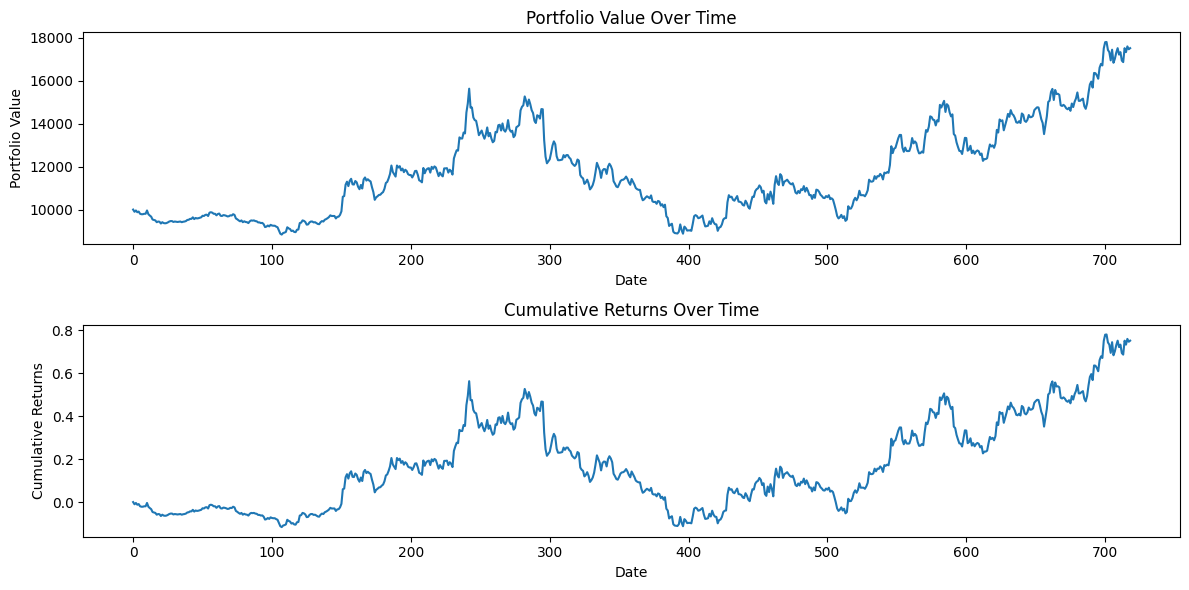

(         date   high   open  close    low        amount        vol  tag  \
 0    20161128   9.78   9.69   9.63   9.60  1.240686e+09  1279689.0    0   
 1    20161129   9.70   9.59   9.62   9.55  8.543080e+08   887779.0    0   
 2    20161130   9.72   9.65   9.55   9.50  9.857580e+08  1025963.0    0   
 3    20161201   9.63   9.57   9.60   9.55  6.196330e+08   646004.0    0   
 4    20161202   9.60   9.60   9.55   9.44  7.900440e+08   829686.0    0   
 ..        ...    ...    ...    ...    ...           ...        ...  ...   
 714  20191104  17.25  16.98  16.92  16.77  1.507911e+09   889824.0    0   
 715  20191105  17.44  16.80  17.15  16.79  2.010924e+09  1172485.0    0   
 716  20191106  17.26  17.06  16.96  16.88  1.470233e+09   863325.0    1   
 717  20191107  17.07  16.93  16.89  16.75  1.200672e+09   711896.0    1   
 718  20191108  17.02  16.98  16.65  16.64  1.421088e+09   849139.0    1   
 
      random_tag  position   returns  portfolio_value  cumulative_returns  
 0        

In [306]:
backtest_buy_hold(valid_ts, initial_capital=10000)